In [ ]:
import cv2
import numpy as np
import os
import glob
import mahotas
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
# --- Extract Features Functions ---

def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(0)
    return haralick

def fd_histogram(image, bins=8):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def fd_glcm(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    glcm = graycomatrix(gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast').flatten()
    dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    asm = graycoprops(glcm, 'ASM').flatten()
    
    return np.hstack([contrast, dissimilarity, homogeneity, energy, correlation, asm])

In [3]:
dataset_path = "Labelled - Copy"
fixed_size = (300, 300)
bins = 8

In [4]:
global_features = []
labels = []

In [5]:
train_labels = os.listdir(dataset_path)
train_labels.sort()

In [6]:
for training_name in train_labels:
    dir = os.path.join(dataset_path, training_name)
    current_label = training_name
    
    file_list = glob.glob(os.path.join(dir, "*"))
    
    for file in file_list:
        image = cv2.imread(file)
        if image is None: continue
        
        image = cv2.resize(image, fixed_size)

        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)
        fv_histogram  = fd_histogram(image, bins)
        
        fv_glcm = fd_glcm(image) 

        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments, fv_glcm])

        labels.append(current_label)
        global_features.append(global_feature)

In [7]:
le = LabelEncoder()
target = le.fit_transform(labels)

In [8]:
for cls, enc in zip(le.classes_, range(len(le.classes_))):
    print(f"{cls} -> {enc}")

Bacterialblight -> 0
BrownSpot -> 1
Healthy -> 2
LeafBlast -> 3


In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)

In [10]:
import joblib
joblib.dump(scaler, "scaler.save")

['scaler.save']

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(
    rescaled_features, target, test_size=0.2, random_state=42, stratify=target
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [12]:
num_classes = len(train_labels)
y_train_hot = to_categorical(y_train, num_classes)
y_val_hot   = to_categorical(y_val, num_classes)
y_test_hot  = to_categorical(y_test, num_classes)

In [13]:
model = Sequential()
input_dim = rescaled_features.shape[1]

model.add(Dense(512, activation='relu', input_shape=(input_dim,)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

C:\Users\Asus TUF\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
history = model.fit(
    X_train, y_train_hot,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_hot),
    verbose=1
)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6451 - loss: 0.8250 - val_accuracy: 0.8327 - val_loss: 0.3632
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8423 - loss: 0.3714 - val_accuracy: 0.8701 - val_loss: 0.3025
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8751 - loss: 0.3014 - val_accuracy: 0.8728 - val_loss: 0.2769
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8689 - loss: 0.3012 - val_accuracy: 0.8688 - val_loss: 0.2949
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8750 - loss: 0.2868 - val_accuracy: 0.8728 - val_loss: 0.2786
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8845 - loss: 0.2650 - val_accuracy: 0.8768 - val_loss: 0.2659
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8839 - loss: 0.2710 - val_accuracy: 0.8822 - val_loss: 0.2689
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8824 - loss: 0.2673 - val_accuracy: 0.

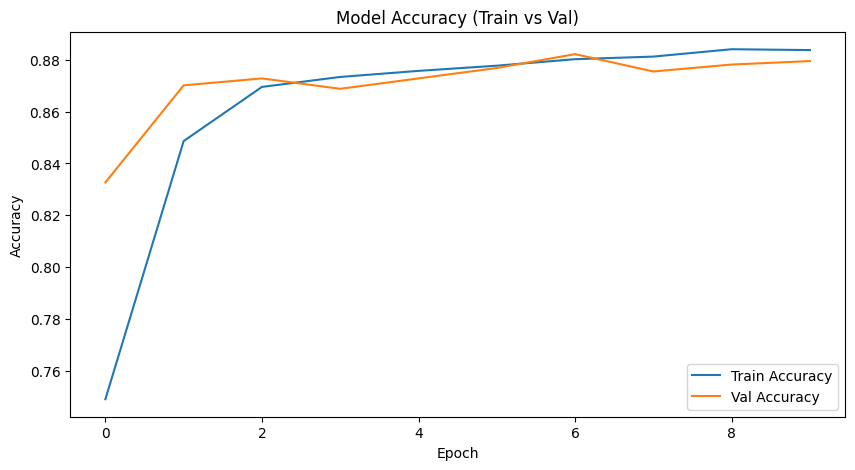

In [16]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy (Train vs Val)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [17]:
results = model.evaluate(X_test, y_test_hot, batch_size=32)
print(f"\nTest Loss     : {results[0]:.4f}")
print(f"Test Accuracy : {results[1]*100:.2f}%")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9019 - loss: 0.2395 

Test Loss     : 0.2481
Test Accuracy : 89.71%


In [18]:
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_hot, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [19]:
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

                 precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00       161
      BrownSpot       0.98      0.93      0.95       215
        Healthy       0.70      0.91      0.79       148
      LeafBlast       0.92      0.78      0.85       224

       accuracy                           0.90       748
      macro avg       0.90      0.91      0.90       748
   weighted avg       0.91      0.90      0.90       748



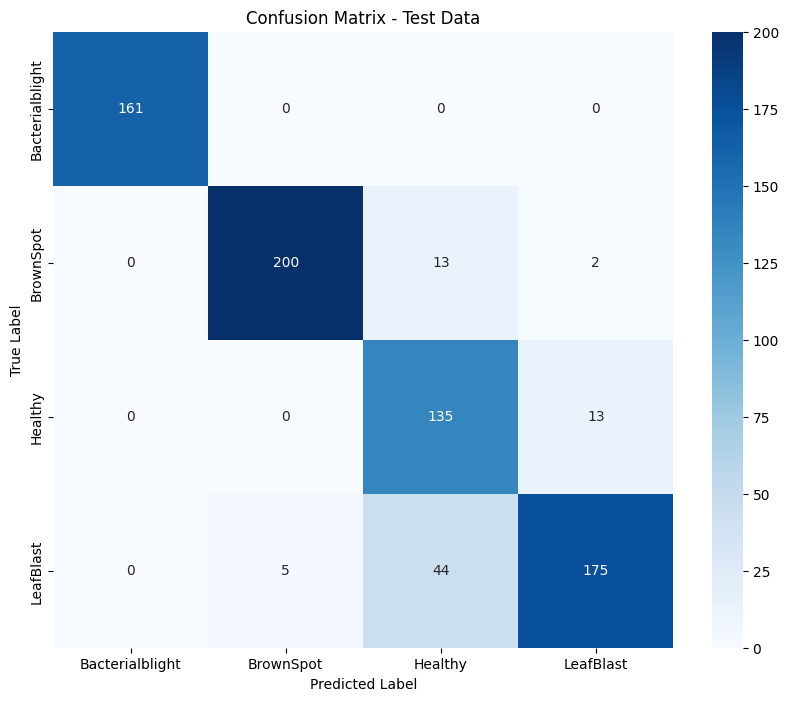

In [20]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [21]:
model.save("model.keras")